# Usage guide to Convenient Interface to Inverse Ising
Edward D. Lee, Bryan C. Daniels  

This notebook gives examples of how to use the various algorithms included in ConIII for solving the inverse Ising problem. 

In this problem, the goal is to match the average orientation of each spin (the magnetization) $\{\langle s_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle s_{\rm i} s_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$. This problem is explained in further detail in the accompanying [paper](https://doi.org/10.5334/jors.217).

## Overview
Each algorithm for solving the inverse Ising problem is contained in a class, an organization principle that may be familiar to users of `scikit-learn`. The algorithms are contained in the `coniii.solvers` module and based off the Solver base class. More architecture details are included in the accompanying paper.

To use an algorithm, an instance of the class must be declared and the `solve()` method called. For some of the solvers, you will also need to pass some helper functions that the algorithm needs. For the case of the pairwise maxent model, these helper functions are already part of the package, and you should be able to import them. The details for writing the particular methods you may need for your problem can be found in the references cited in the [paper](https://doi.org/10.5334/jors.217).

Most of the classes require the user to specify the maxent problem by defining `calc_observables()`. Here, "observables" refers to the constraints that are imposed in the model, and these must be calculated from some sample of states. The term "multipliers" refers to Langrangian multipliers (or parameters) that are found such that the constraints are met.

This notebook is structured such that it starts with setting up a simple $n=5$ model to solve. In this case, there are 15 parameters to find. Five parameters are the mean fields $h_{\rm i}$ corresponding to the mean orientation (magnetization) of the spins and ten parameters are for the pairwise couplings $J_{\rm ij}$ corresponding to the pairwise correlations. At the end of the notebook, we show how one can extend the package to handle higher order interactions (triplet interactions) with the MPF and MCH algorithms.

Feel free to open an issue on our GitHub page if you have any questions, comments, or feature requests. We welcome feedback!

In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

Populating the interactive namespace from numpy and matplotlib


# Setup
This section sets up an $n=5$ Ising problem to test. 

We define the model by choosing some random fields and couplings and sampling from the resulting distribution. This serves as an example problem where the true correlations and parameters are known and gives us a sense of how the different algorithms work on the inverse problem.

In [15]:
# Import common libraries.
from coniii import *
# Import file containing full equations for solving the n=5 system.
from coniii.ising_eqn import ising_eqn_5_sym

# Define common functions.
calc_e, calc_observables, mchApproximation = define_ising_helper_functions()

# Generate example data set.
n = 9  # system size
np.random.seed(0)  # standardize random seed
h = np.random.normal(scale=.1, size=n)           # random couplings
J = np.random.normal(scale=.1, size=n*(n-1)//2)  # random fields
hJ = np.concatenate((h, J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact means and pairwise correlations

allstates = bin_states(n, True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[np.random.choice(range(2**n),
                                    size=100,
                                    replace=True,
                                    p=p)]  # random sample from p(s)
sisj = pair_corr(sample, concat=True)  # means and pairwise correlations

# Useful functions for measuring success fitting procedure.
def error_on_correlations(estSisj):
    return np.linalg.norm( sisj - estSisj )

def error_on_multipliers(estMultipliers):
    return np.linalg.norm( hJ - estMultipliers )

ValueError: a and p must have same size

# Enumeration

The Enumerate class implements the most direct approach to solving the inverse Ising problem by writing out all the constraint equations. This involves enumerating all the terms in the partition function $Z$. Then, we find the solution using `scipy.optimize.root` as detailed in the `Enumerate.solve` method.
<br><br><br>
Using the Enumerate class consists of a few steps.
1. Use `enumerate.py` helper module to write the equations corresponding to the system of interest. All pairwise Ising systems from sizes $n=2$ up to $n=9$ are already included in the `coniii.ising_eqn` module. But as an example, we can write the equations for the $n=5$ Ising model that we use in this notebook. First, you navigate to the installation directory in the site-package directory (this can be found by running `import coniii` and then `coniii.__path__`). Then, run in the terminal,<br><br>
`python enumerate.py 5 1`<br>  
The first argument to `enumerate.py` is the system size and the 1 indicates that the equations should be written for the symmetric Ising model $\sigma_{\rm i}\in\{-1,1\}$. For $\sigma_{\rm i}\in \{0,1\}$, we would put a 0 instead. The naming convention is "ising_eqn_[n][\_sym].py" where n is the system size and "\_sym" is the suffix if the spins are symmetric. Some more details are in the __main__ block at the bottom of `enumerate.py`. Note that file size grows exponentially with the size of the system!


3. Define the function for calculating the observables (usually the mean of each spin and pairwise correlations) using the parameters (Langrangian multipliers). This will be passed into `calc_observables_multipliers`.<br><br>
2. Use the Enumerate class to solve the equations written in the resulting file.

As a test of the Enumerate class below, we show that fitting to the known values of $\langle\sigma_{\rm i}\rangle$ and $\langle\sigma_{\rm i}\sigma_{\rm j}\rangle$ recovers the exact values of the parameters. Unfortunately, this approach scales very poorly (exponentially in memory and time) for large systems.<br><br>
#### Addenda (added April 2019)
- High precision versions of the Ising model equations using the mpmath module are possible with the `-hp=true` keyword argument.
- The `enumerate_potts.py` module provides limited support for Potts models. At the moment, functionality for writing the $k$-Potts model with $k$-dimensional field terms but only couplings for the average correlation across all $k$ dimensions is supported.

In [24]:
# Define function specifically needed for creating Enumerate class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers. For
    the Ising model, these are the means of each spin and the pairwise correlations.
    
    This is analogous to the calculation happening in ising_eqn_5_sym.calc_observables().
    This means that ising_eqn_5_sym.calc_observables could be passed into the keyword arg
    below instead, but we have explicitly defined this function here for demo purposes.
    """
    
    E = calc_e(allstates, J)
    return pair_corr( allstates, np.exp(-E-logsumexp(-E)), concat=True )

# Declare and call solver.
# For this example, we show that numerically exact results can be found when the exact 
# correlations are given. In general, exact correlations are not known and they must be 
# estimated from the data.
solver = Enumerate(n,
                   calc_observables_multipliers=calc_observables_multipliers,
                   calc_observables=calc_observables)
estMultipliers = solver.solve(constraints=sisjTrue)

print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
print("Error on sample corr: %E"%error_on_correlations(
                        ising_eqn_5_sym.calc_observables(estMultipliers)))

Error on multipliers: 2.494566E-16
Error on sample corr: 4.023216E-01


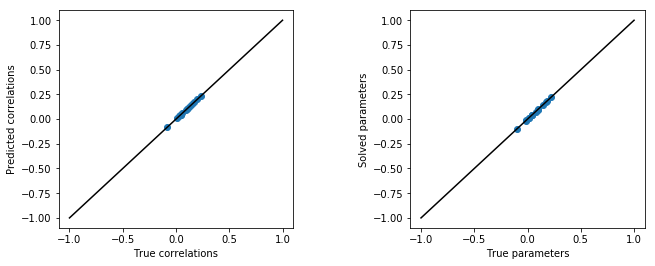

In [25]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisjTrue, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='True correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Minimum probability flow (MPF)
MPF involves minimizing a much simpler objective function. One component that is necessary is the connectivity matrix defining which states are connected to each other such that probability can flow between them. This is defined in the `adj()` function for the Ising model.

MPF is easily generalizable to arbitrary constraints by modifying `calc_observables()`.

MPF is not expected to return the exact solution, but usually the estimated parameters are quite close to the ones calculated using MCH (shown below) while running faster. Note that MPF is given a finite sample from the true distribution to solve for, so we do not expect that it recover the same parameters, but it matches the correlations quite closely as measured with MCMC sampling.

In [47]:
adj(np.array([-1,1,1,1,1]))

array([[ 2.,  1.,  1.,  1.,  1.],
       [-1.,  0.,  1.,  1.,  1.],
       [-1.,  1.,  0.,  1.,  1.],
       [-1.,  1.,  1.,  0.,  1.],
       [-1.,  1.,  1.,  1.,  0.]])

In [38]:
# Declare and call solver.
# adj() was imported from coniii.utils at the beginning. It is a function for finding all 
# the neighbors of a given state and is necessary for the MPF algorithm (called g_ij in 
# Sohl-Dickstein 2011).
solver = MPF(n, 
             calc_observables=calc_observables,
             adj=adj)
estMultipliers = solver.solve(samples)

#print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
#print("Error on sample corr: %E"%error_on_correlations(
                  #      ising_eqn_5_sym.calc_observables(estMultipliers)))

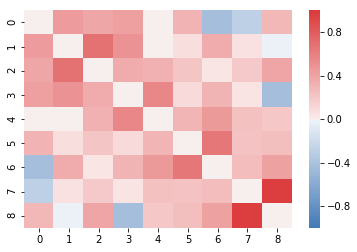

In [39]:
plot_heatmap(squareform(estMultipliers[9:]))

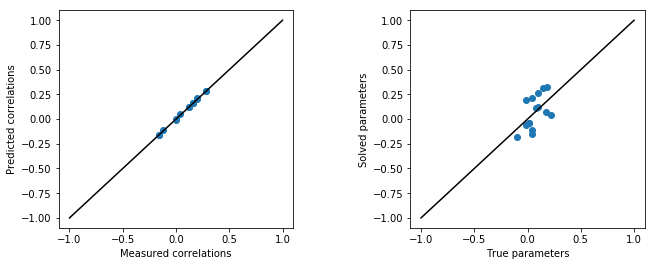

In [6]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4), ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='True parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood
Pseudollikelihood requires calculating the conditional probability for a single spin given the rest of the system  
>$p_{\rm r}=\left.p(\sigma_{\rm r}\right|\sigma\backslash\sigma_{\rm r})$.

As a result, there is no guarantee that pseudolikelihood comes close to the solution, but it usually does quite well as shown below.

The Pseudo class is written specifically for the pairwise Ising model. It requires that the user define a function `get_multipliers_r()` that retrieves the parameters from the parameters vector relevant for calculating $p_{\rm r}$ and `calc_observables_r()` that calculates $p_{\rm r}$ from a sample of states. Template functions that work for the Ising model are defined in `utils.define_pseudo_ising_helpers()`.<br><br>

## Notes
- The coupling matrix is constrained to be symmetric in the code below $J_{\rm ij}=J_{\rm ji}$.

In [17]:
get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)

solver = Pseudo(n,
                calc_observables=calc_observables,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r)
estMultipliers = solver.solve(samples, zeros(45))

#print("Error on multipliers: %E"%error_on_multipliers(estMultipliers))
#print("Error on sample corr: %E"%error_on_correlations(
               #         ising_eqn_5_sym.calc_observables(estMultipliers)))

In [23]:
from scipy.spatial.distance import squareform

In [26]:
import seaborn as sns

In [28]:
from copy import deepcopy

In [31]:
estMultipliers[:9]

array([ 0.38567476,  0.23202279,  0.50497848, -0.02758681, -0.1544198 ,
        0.02173997, -0.34894007, -0.07339265, -0.5605701 ])

In [35]:
J = np.loadtxt("jij_correct_solution.csv", delimiter=",")

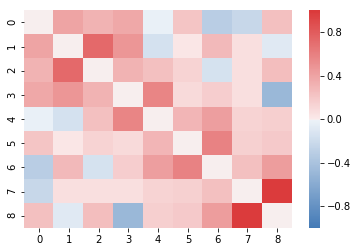

In [36]:
plot_heatmap(J)

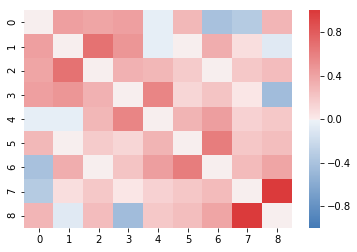

In [34]:
plot_heatmap(squareform(estMultipliers[9:]))

In [33]:
def plot_heatmap(J):
    J_ = deepcopy(J)
    if J_.shape != (9,9): J_ = J_.reshape((9,9))
    cm = sns.diverging_palette(248, 12, sep=1, n=256)
    sns.heatmap(J_, cmap=cm, vmin=-1, vmax=1)

In [24]:
squareform(estMultipliers)

array([[ 0.        ,  0.38567476,  0.23202279,  0.50497848, -0.02758681,
        -0.1544198 ,  0.02173997, -0.34894007, -0.07339265, -0.5605701 ],
       [ 0.38567476,  0.        ,  0.42732688,  0.39384215,  0.42633544,
        -0.04360895,  0.28679396, -0.41403695, -0.33210116,  0.30406631],
       [ 0.23202279,  0.42732688,  0.        ,  0.68227178,  0.47977614,
        -0.04514596,  0.0073031 ,  0.34772816,  0.07465052, -0.08158133],
       [ 0.50497848,  0.39384215,  0.68227178,  0.        ,  0.32724694,
         0.29349258,  0.18558841,  0.00736684,  0.19835157,  0.25792176],
       [-0.02758681,  0.42633544,  0.47977614,  0.32724694,  0.        ,
         0.57597352,  0.11806366,  0.22376619,  0.02605272, -0.44974921],
       [-0.1544198 , -0.04360895, -0.04514596,  0.29349258,  0.57597352,
         0.        ,  0.30723414,  0.43504162,  0.14548467,  0.19938351],
       [ 0.02173997,  0.28679396,  0.0073031 ,  0.18558841,  0.11806366,
         0.30723414,  0.        ,  0.61850316

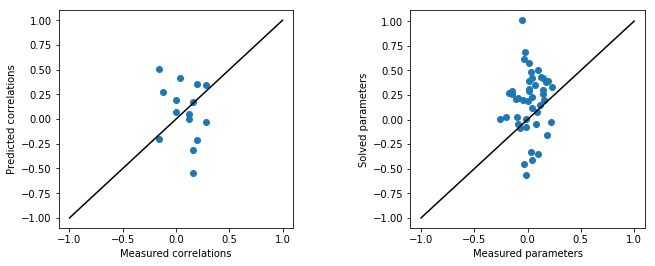

In [18]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj, ising_eqn_5_sym.calc_observables(estMultipliers), 'o')
ax[0].plot([-1,1], [-1,1], 'k-')
ax[0].set(xlabel='Measured correlations', ylabel='Predicted correlations')

ax[1].plot(hJ, estMultipliers, 'o')
ax[1].plot([-1,1], [-1,1], 'k-')
ax[1].set(xlabel='Measured parameters', ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)